# 0. Install and Import Dependencies

In [ ]:
%pip install opencv-python==4.6.0.66 tensorflow==2.10.1 imageio==2.23.0 numpy==1.24.1 matplotlib==3.6.2 streamlit gdown==4.6.0

In [79]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
altair                       5.3.0
asttokens                    2.4.1
astunparse                   1.6.3
attrs                        23.2.0
beautifulsoup4               4.12.3
blinker                      1.8.2
cachetools                   5.3.3
certifi                      2024.6.2
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.2
decorator                    5.1.1
exceptiongroup               1.2.1
executing                    2.0.1
filelock                     3.15.4
flatbuffers                  24.3.25
fonttools                    4.53.0
gast                         0.4.0
gdown                        4.6.0
gitdb                        4.0.11
GitPython                    3.1.43


In [6]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [7]:
tf.config.list_physical_devices('GPU')

[]

In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip' 
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [12]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [13]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [14]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [15]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [16]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [17]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [18]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [19]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #File name splitting for lINUX
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [20]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [21]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [22]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

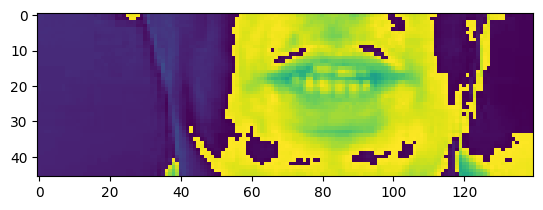

In [23]:
plt.imshow(frames[40])

In [24]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [25]:
#Converts the numerical alignments back to characters and joins them into a single string.

tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [26]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [27]:
from matplotlib import pyplot as plt

In [28]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [29]:
#Finding the Length of the Test Dataset:
len(test)

50

In [30]:
#Getting the Next Batch of Data:
frames, alignments = data.as_numpy_iterator().next()

In [31]:
# Finding the no. of frames in each batch
len(frames)

2

In [32]:
#Get the next batch Using an Iterator:


sample = data.as_numpy_iterator()
val = sample.next(); 
val[0]

array([[[[[1.4433954 ],
          [1.4433954 ],
          [1.4054112 ],
          ...,
          [9.420054  ],
          [0.11395226],
          [0.07596818]],

         [[1.4433954 ],
          [1.4433954 ],
          [1.4054112 ],
          ...,
          [9.534006  ],
          [0.07596818],
          [9.647959  ]],

         [[1.253475  ],
          [1.253475  ],
          [1.253475  ],
          ...,
          [0.18992044],
          [0.11395226],
          [0.11395226]],

         ...,

         [[0.9116181 ],
          [0.9116181 ],
          [0.9116181 ],
          ...,
          [9.609975  ],
          [9.685943  ],
          [9.685943  ]],

         [[0.9116181 ],
          [0.9116181 ],
          [0.9116181 ],
          ...,
          [9.496022  ],
          [9.609975  ],
          [9.609975  ]],

         [[0.9116181 ],
          [0.9116181 ],
          [0.9116181 ],
          ...,
          [9.496022  ],
          [9.57199   ],
          [9.57199   ]]],


        [[[1.3674

In [33]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.685942649841309]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.685942649841309]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.685942649841309]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.685942649841309]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.685942649841309]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.685942649841309]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.685942649841309]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

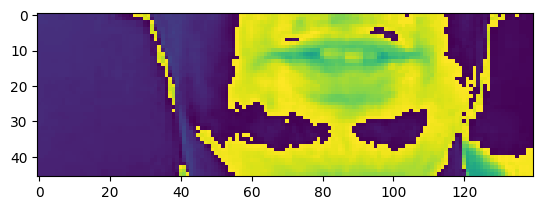

In [34]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [35]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place blue by v seven soon'>

# 3. Design the Deep Neural Network

In [36]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import Orthogonal

In [37]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [38]:
#Initialize the model
model = Sequential()

#First Convolutional Block
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

#Second Convolutional Block
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

#Third Convolutional Block
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

#Recurrent Layer
model.add(TimeDistributed(Reshape((-1,))))

#First Bidirectional LSTM Block
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

#Second Bidirectional LSTM Block
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

#Output Layer
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [40]:
5*17*75

6375

In [41]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [42]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b"''''''uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu">

In [43]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b"''''''uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu">

In [44]:
model.input_shape

(None, 75, 46, 140, 1)

In [45]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [46]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [47]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [48]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [49]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [50]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [51]:
schedule_callback = LearningRateScheduler(scheduler)

In [52]:
example_callback = ProduceExample(test)

In [49]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


# 5. Make a Prediction 

In [49]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: c:\Users\bhuva\Desktop\Data Science\Projects\LipNet-main\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:11<00:00, 8.08MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [63]:
model.load_weights('models/checkpoint')


In [64]:
test_data = test.as_numpy_iterator()

In [65]:
sample = test_data.next()

In [68]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [69]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green in z two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green by n nine soon'>]

In [70]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [71]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green in z two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green by n nine soon'>]

# Test on a Video

In [72]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [73]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [74]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 981ms/step


In [75]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [76]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]